# Training

In [195]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd

In [196]:
import torch

In [197]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [198]:
#getting path for the dataset
path2 = os.path.join(os.getcwd(), "Logo_classif3")

In [199]:
#applying a transform on all images and building the dataset
transform = transforms.Compose([
transforms.Resize((128, 128)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)
])

logos = ImageFolder(path2, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


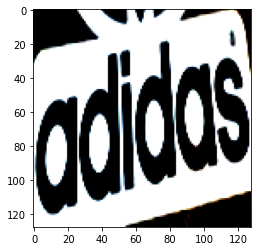

In [200]:
plt.imshow(logos[152][0].permute(1, 2, 0))

In [201]:
#checking length of dataset
len(logos)

4578

In [202]:
#checking how many classes are present in the dataset
len(logos.classes)

47

In [203]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [204]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [205]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

In [206]:
#create a dataset class
class Logos(Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        sample = {"pic": self.X[index][0], "label": self.X[index][1]}
        return sample

In [207]:
full_data = Logos(logos)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


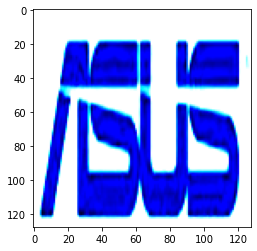

In [208]:
#checking if __getitem__() works
plt.imshow(full_data[0]["pic"].permute(1, 2, 0))

In [209]:
#calculating train and test size, train size is about 80% of the whole dataset
train_size = int(0.8*len(logos))
test_size = len(logos) - train_size
train_size, test_size

(3662, 916)

In [210]:
#splitting whole dataset into train and test
train_data, test_data = torch.utils.data.random_split(full_data, (train_size, test_size))

In [211]:
train_data = torch.utils.data.Subset(train_data, np.arange(train_size))

In [212]:
test_data = torch.utils.data.Subset(test_data, np.arange(test_size))

In [213]:
import torch.nn as nn

In [214]:
import torchvision

In [215]:
#printing model so I can look at the fc to get the in_features variable
torchvision.models.resnet18(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [216]:
#a function to modify the last layer of the model
def get_model(n_classes):
    model = torchvision.models.resnet18(pretrained=True)
    in_features = 512
    model.fc = nn.Linear(in_features=in_features, out_features=n_classes)
    return model

In [217]:
model = get_model(len(logos.classes)).to(device=device)
model.to(device=device)

#getting the model parameters that require grad to insert into the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)

In [218]:
#creating a train- and test dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64,
shuffle=True)

In [250]:
for i in range(10):
    print(train_data[-i]["label"])

46
35
23
0
32
34
34
36
28
1


In [219]:
len(train_loader)

58

In [220]:
len(test_loader)

15

In [221]:
n_epochs = 3

In [222]:
import datetime

In [228]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    #these arrays are just for plotting the accuracies and losses
    train_acc = np.zeros(n_epochs)
    test_acc = np.zeros(n_epochs)
    train_loss_list = np.zeros(n_epochs)
    test_loss_list = np.zeros(n_epochs)

    
    with torch.cuda.device(0):
        #train loop
        for epoch in range(n_epochs):
            #some dummy variables to calculate accuracies and losses
            loss_train = 0.0
            loss_test = 0.0
            total = 0
            correct = 0
            out_correct = 0
            
            for items in train_loader:
                outputs = model(items["pic"].to(device=device))
                loss = loss_fn(outputs, items["label"].to(device=device))

                optimizer.zero_grad()

                loss.backward()
                
                optimizer.step()

                loss_train += loss.item()

                #the prediction is the argument of the largest value in the output vector
                _, pred = torch.max(outputs, dim=1)
                correct += int((pred == items["label"].to(device=device)).sum())

            #test loop
            with torch.no_grad():
                for sample in test_loader:
                    
                    train_out = model(sample["pic"].to(device=device))
                    out_loss = loss_fn(train_out, sample["label"].to(device=device))
                    
                    #the prediction is the argument of the largest value in the output vector
                    _, out_pred = torch.max(train_out, dim=1)
                    out_correct += int((out_pred == sample["label"].to(device=device)).sum())
                    loss_test += out_loss.item()
            
            #calculating accuracies and losses
            train_acc[epoch] = correct / len(train_data)
            test_acc[epoch] = out_correct / len(test_data)
            train_loss_list[epoch] = loss_train / len(train_loader)
            test_loss_list[epoch] = loss_test / len(train_loader)
            
            #this prints every epochs if the model went through less than 10 epochs
            #otherwise it prints every 10 epochs
            if epoch < 10 or (epoch) % 10 == 0:
                print("-----------------------------------------------------")
                print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, train_loss_list[epoch]))
                print('Training accuracy: {}'.format(train_acc[epoch]))
                print('Test loss: {}'.format(test_loss_list[epoch]))
                print('Test accuracy {}'.format(test_acc[epoch]))
    
    #plotting train and test accuracy at each epoch
    plt.plot(np.arange(n_epochs), train_acc)
    plt.plot(np.arange(n_epochs), test_acc)

In [229]:
loss_fn = nn.CrossEntropyLoss()

In [230]:
#just checking if model outputs a vector of necessary length
model(train_data[0]["pic"].unsqueeze(0).to(device=device))

tensor([[-1.0529, -0.4099, -0.1465, -0.4562, -0.3476, -1.6285, -1.7875, -1.4950,
          0.5112, -1.4844, -1.0108, -0.1797, -1.6513, -2.7067, -2.4252, -0.9196,
         -2.2725, -0.4406, -1.6823, -1.5412, -0.1175, -0.8599, -1.6078, -1.2342,
         -3.2927,  0.1035, -0.8501, -0.6075, -0.5261, -0.5046, -2.6370,  0.2638,
         -0.0102, -0.9216,  0.2644, -0.2672,  0.1834, -1.2686, -2.6217, -0.9612,
         -0.5152, -0.8189, -0.5665, -0.9005, -1.6799, -0.9292, -1.2237]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [231]:
model(train_data[0]["pic"].unsqueeze(0).to(device=device)).shape

torch.Size([1, 47])

-----------------------------------------------------
2021-09-23 17:11:13.148694 Epoch 0, Training loss 0.4369471651212922
Training accuracy: 0.8940469688694702
Test loss: 0.09144445405951862
Test accuracy 0.9137554585152838
-----------------------------------------------------
2021-09-23 17:11:29.788512 Epoch 1, Training loss 0.2118576163233354
Training accuracy: 0.9448388858547242
Test loss: 0.0642456427730363
Test accuracy 0.9344978165938864
-----------------------------------------------------
2021-09-23 17:11:47.083787 Epoch 2, Training loss 0.14024269840969095
Training accuracy: 0.9675040961223376
Test loss: 0.06388656666566586
Test accuracy 0.9421397379912664


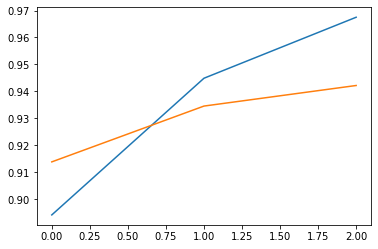

In [232]:
training_loop(
n_epochs = n_epochs,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

In [234]:
#creating a directory for the model to save in
os.mkdir('logos_model')

In [235]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), "logos_model\\logos_model.pth"))

In [236]:
loaded_model = get_model(n_classes=47).to(device=device)
loaded_model.load_state_dict(torch.load(os.path.join(os.getcwd(), "logos_model\\logos_model.pth")))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


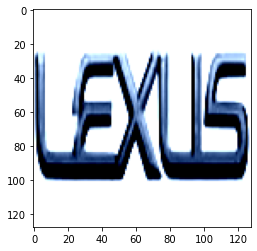

In [237]:
plt.imshow(test_data[i]["pic"].permute(1, 2, 0))

In [238]:
pred = np.zeros(len(test_data))
true = np.zeros(len(test_data))
correct = 0

#attempting a few predictions
#accuracy is very low
with torch.no_grad():
    for i in range(len(test_data)):
        out = loaded_model(test_data[i]["pic"].unsqueeze(0).to(device=device))
        pred[i] = torch.argmax(out)
        true[i] = test_data[i]["label"]
        if pred[i] == true[i]:
            correct += 1
print("Accuracy:", correct/len(test_data))

Accuracy: 0.08733624454148471


In [239]:
pred

array([31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31

In [240]:
true

array([35., 25., 46., 25.,  6.,  6.,  2., 27., 28., 33., 46.,  3., 46.,
       34., 26., 32., 41., 32.,  5., 15., 36., 31., 46., 46., 10., 23.,
       37., 26.,  0., 43., 45., 33., 25., 16., 16., 26., 31., 36., 31.,
       37., 34., 34., 35., 22., 43., 43., 22., 29., 31., 40., 32., 46.,
       23., 33., 21., 33.,  4., 39., 46., 11., 40., 31., 42., 31., 16.,
        3., 34., 33., 31., 10., 31., 31.,  3., 15., 23., 27.,  1., 46.,
       46., 40., 27.,  2.,  4., 31., 34., 34., 36., 25., 36., 40., 11.,
       34.,  6., 13., 16., 42., 28., 34., 27., 13., 25., 10., 21.,  6.,
       40., 36., 20., 25., 11., 31., 27., 26., 32.,  2.,  4., 10.,  7.,
       34., 44.,  1., 37.,  4., 42.,  3., 19., 10., 17.,  0., 42.,  9.,
       18., 15., 32., 44., 31., 22., 25., 21., 46., 34.,  7., 36., 22.,
       10., 31.,  1., 34., 34., 21., 28.,  4., 42., 42., 34., 36.,  8.,
       17.,  8., 36., 26., 33., 11., 34., 27., 31., 39., 44., 42., 27.,
       43., 36., 18., 33., 31., 31., 31., 45., 17., 17., 32., 46

In [241]:
len(test_data)

916

In [242]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [243]:
#create a confusion matrix from above predictions
cm = confusion_matrix(true, pred)

In [244]:
#create an object that allows me to display the above matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = logos.classes)

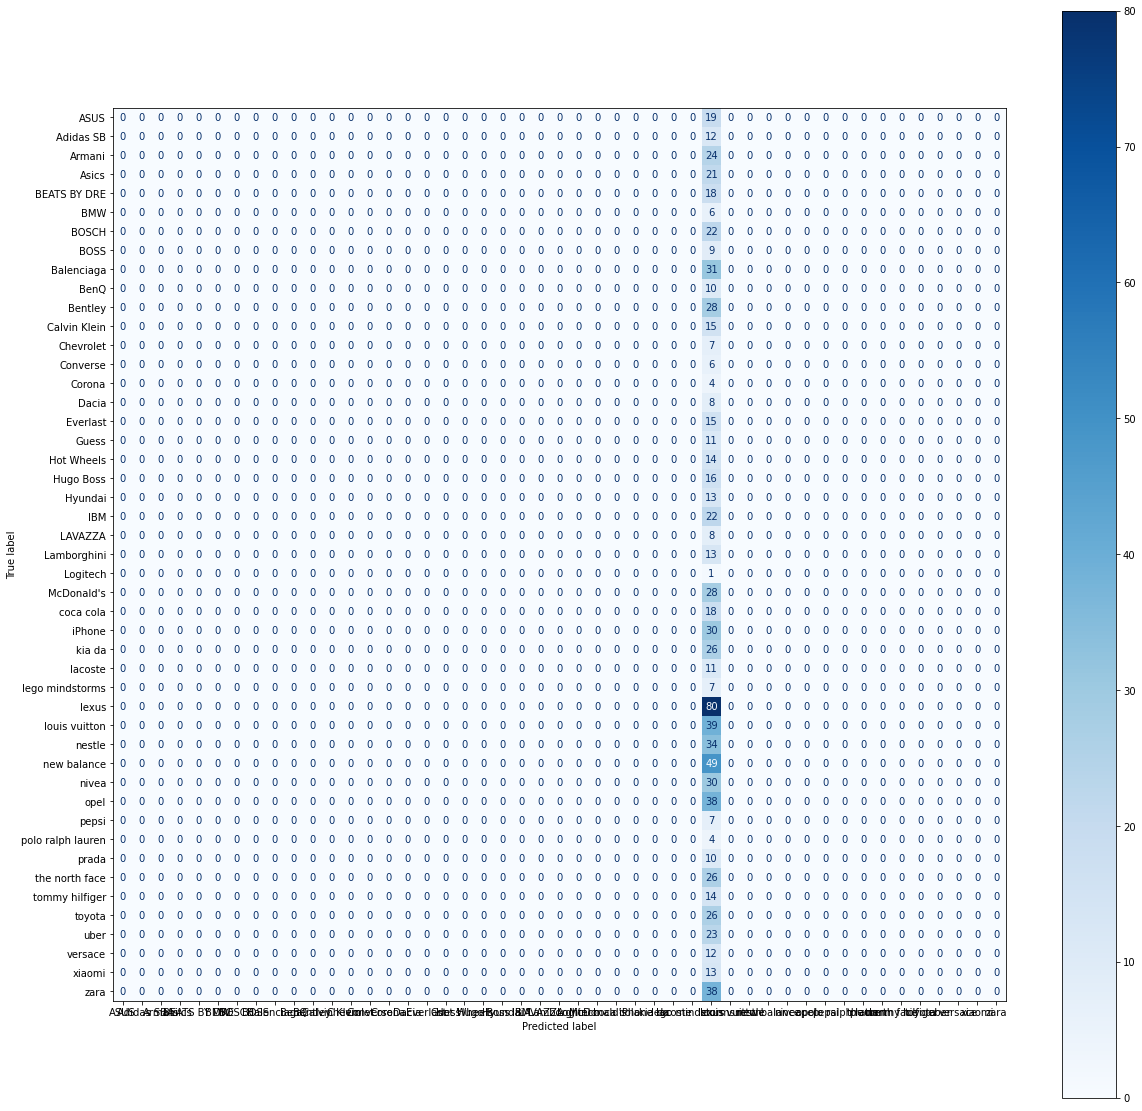

In [245]:
#displaying the confusion matrix
#idk why i got this error, it never showed up before
#matrix still displays though
disp = disp.plot(cmap = "Blues", ax=plt.subplots(figsize=(20, 20))[1]) 